In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import atlite
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import xesmf as xe

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
from regridding_functions import read_and_average_era5_marta
from regridding_functions import read_and_average_sarah
rsds_era5_mean= read_and_average_era5_marta('influx_direct')
rsds_sarah_mean= read_and_average_sarah('influx_direct')

['/groups/EXTREMES/cutouts/europe-2010-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc']


In [10]:
ds_sarah3= xr.open_dataset('/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc')
ds_era5= xr.open_dataset('/groups/EXTREMES/cutouts/europe-2010-era5.nc')

In [11]:
ds_sarah3

<xarray.Dataset> Size: 13GB
Dimensions:           (x: 177, y: 131, time: 8760)
Coordinates:
  * x                 (x) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 40.2 40.5 40.8
  * y                 (y) float64 1kB 33.0 33.3 33.6 33.9 ... 71.4 71.7 72.0
  * time              (time) datetime64[ns] 70kB 2010-01-01 ... 2010-12-31T23...
    lon               (x) float64 1kB ...
    lat               (y) float64 1kB ...
Data variables: (12/13)
    influx_direct     (time, y, x) float32 812MB ...
    influx_diffuse    (time, y, x) float32 812MB ...
    solar_altitude    (time, y, x) float64 2GB ...
    solar_azimuth     (time, y, x) float64 2GB ...
    height            (y, x) float32 93kB ...
    wnd100m           (time, y, x) float32 812MB ...
    ...                ...
    roughness         (time, y, x) float32 812MB ...
    influx_toa        (time, y, x) float32 812MB ...
    albedo            (time, y, x) float32 812MB ...
    temperature       (time, y, x) float64 2GB ...
    soil temperature  (time, y, x) float64 2GB ...
    runoff            (time, y, x) float32 812MB ...
Attributes: (12/46)
    module:                     ['sarah', 'era5']
    prepared_features:          ['height', 'influx', 'runoff', 'temperature',...
    chunksize_lat:              -1
    chunksize_time:             100
    sarah_dir:                  data
    dx:                         0.3
    ...                         ...
    instrument:                 SEVIRI > Spinning Enhanced Visible and Infrar...
    variable_id:                SIS
    license:                    The CM SAF data are owned by EUMETSAT and are...
    title:                      CM SAF Surface Solar Radiation Climate Data R...
    summary:                    This file contains data from the CM SAF Surfa...
    history:                    2022-07-08 14:42:21 GMT by grib_to_netcdf-2.2...

In [12]:
ds_selected = ds_sarah3['influx_direct'].sel(y=slice(65,72))
nonzero_valid_count = np.count_nonzero((ds_selected.values != 0) & ~np.isnan(ds_selected.values))

print(f"Number of values that are not 0 and not NaN: {nonzero_valid_count}")

Number of values that are not 0 and not NaN: 0


In [13]:
rsds_era5_mean_cut=rsds_era5_mean.sel(x=slice(-12, 35), y=slice(33, 64.8))
rsds_sarah_mean_cut=rsds_sarah_mean.sel(x=slice(-12, 35), y=slice(33, 64.8))

In [14]:
from regridding_functions import regrid
regridder=regrid(rsds_era5_mean_cut, rsds_sarah_mean_cut, method='conservative')

189 190
128 129
157 158
107 108


In [16]:
rsds_era5_mean_interp_cut=regridder(rsds_era5_mean_cut)
rsds_era5_mean_interp_cut

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_direct as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (lat: 107, lon: 157)> Size: 67kB
dask.array<astype, shape=(107, 157), dtype=float32, chunksize=(107, 157), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 856B 33.0 33.3 33.6 33.9 34.2 ... 63.9 64.2 64.5 64.8
  * lon      (lon) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 33.9 34.2 34.5 34.8
Attributes:
    regrid_method:  conservative

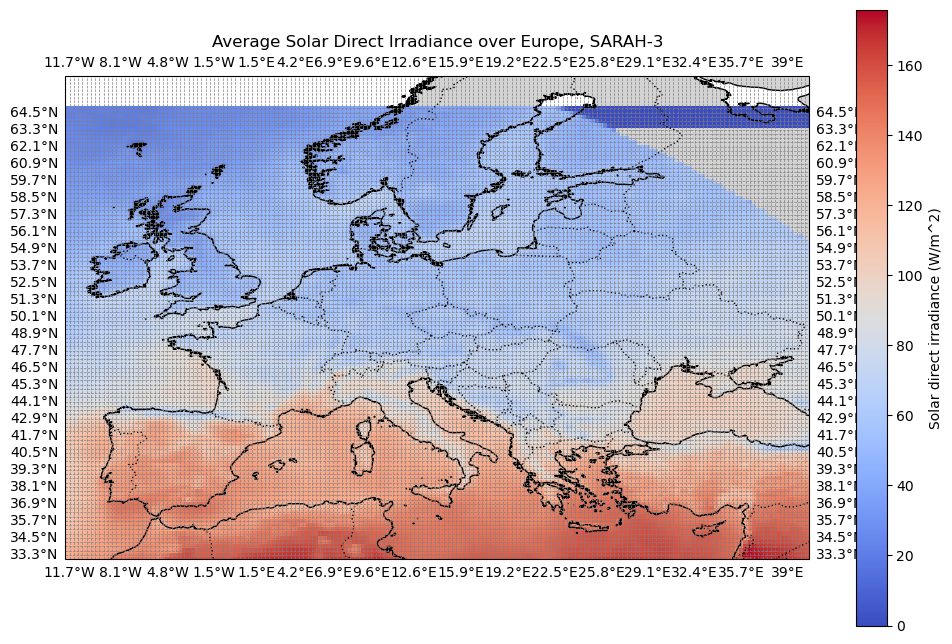

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract the longitude and latitude from the dataset
lon = rsds_sarah_mean.lon
lat = rsds_sarah_mean.lat

# Create the figure and axes with a PlateCarree projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the solar irradiance at the selected time
rsds_sarah_mean.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for solar irradiance
    cbar_kwargs={'label': 'Solar direct irradiance (W/m^2)'}
)

# Add map features for context
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Set extent to Europe using the min and max of the lon and lat from the data
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

# Add gridlines for each latitude and longitude
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', xlocs=lon, ylocs=lat, x_inline=False, y_inline=False)

# Add title and labels
plt.title(f'Average Solar Direct Irradiance over Europe, SARAH-3')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

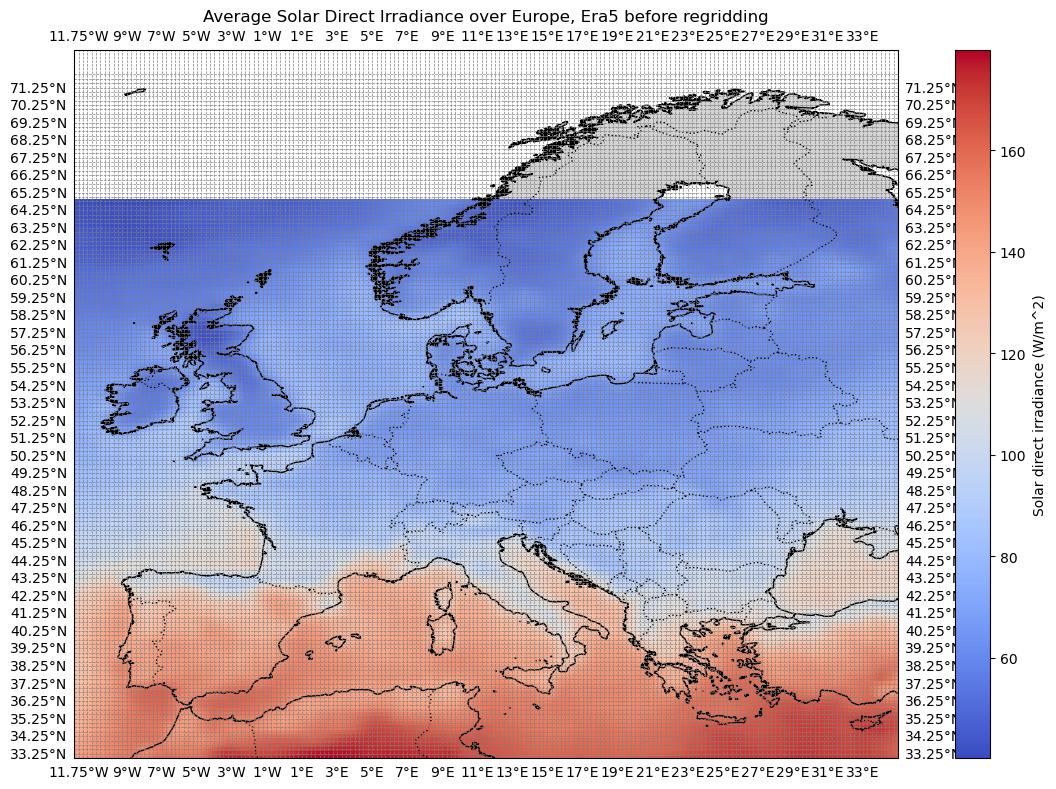

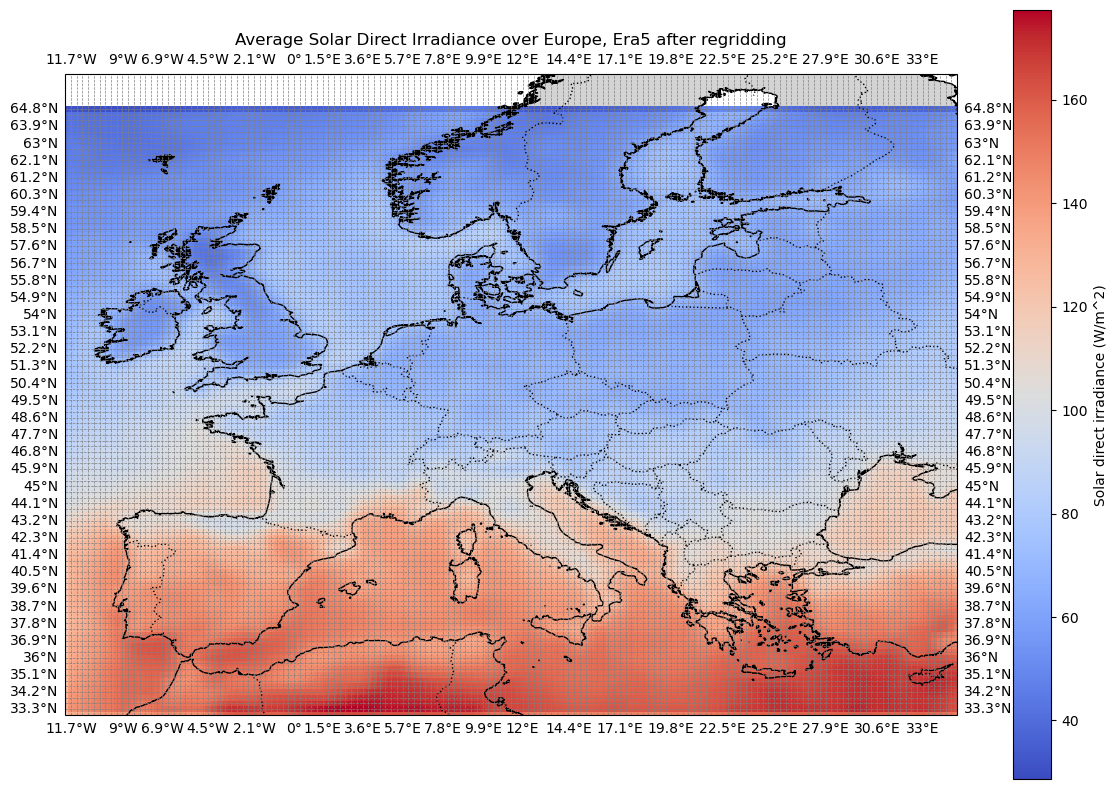

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract the longitude and latitude from the datasets
lon_era5 = rsds_era5_mean.lon
lat_era5 = rsds_era5_mean.lat
lon_era5_interp_cut = rsds_era5_mean_interp_cut.lon
lat_era5_interp_cut = rsds_era5_mean_interp_cut.lat

# Create the figure for rsds_era5_mean (before regridding)
fig1, ax1 = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.set_title('rsds_era5_mean (Before Regridding)')
rsds_era5_mean_cut.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for solar irradiance
    cbar_kwargs={'label': 'Solar direct irradiance (W/m^2)'}
)

# Add map features for context
ax1.coastlines(resolution='10m', linewidth=1)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')

# Add gridlines for exact latitude and longitude points (before regridding)
ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', xlocs=lon_era5, ylocs=lat_era5, x_inline=False, y_inline=False)

# Set the extent to Europe for the first plot
ax1.set_extent([lon_era5.min(), lon_era5.max(), lat_era5.min(), lat_era5.max()])

# Show the first plot
plt.title(f'Average Solar Direct Irradiance over Europe, Era5 before regridding')
plt.tight_layout()
plt.show()

# Create the figure for rsds_era5_mean_interp (after regridding)
fig2, ax2 = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax2.set_title('rsds_era5_mean_interp (After Regridding)')
rsds_era5_mean_interp_cut.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for solar irradiance
    cbar_kwargs={'label': 'Solar direct irradiance (W/m^2)'}
)

# Add map features for context
ax2.coastlines(resolution='10m', linewidth=1)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')

# Add gridlines for exact latitude and longitude points (after regridding)
ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', xlocs=lon_era5_interp_cut, ylocs=lat_era5_interp_cut, x_inline=False, y_inline=False)

# Set the extent to Europe for the second plot
ax2.set_extent([lon_era5_interp_cut.min(), lon_era5_interp_cut.max(), lat_era5_interp_cut.min(), lat_era5_interp_cut.max()]) #I choose the smaller coordinate range from Era5

# Show the second plot
plt.title(f'Average Solar Direct Irradiance over Europe, Era5 after regridding')
plt.tight_layout()
plt.show()

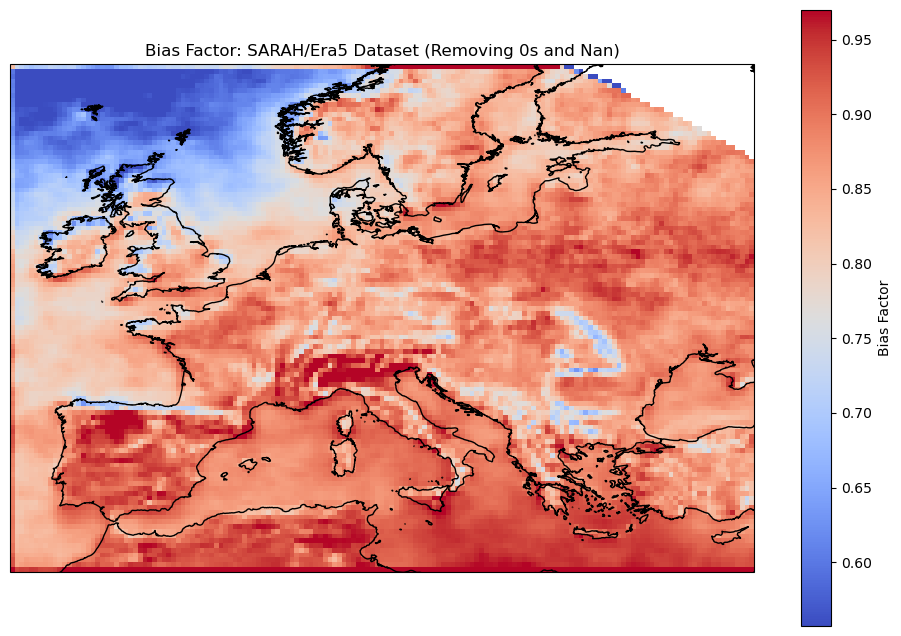

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming these variables exist
denominator = rsds_era5_mean_interp_cut.values  # ERA5 dataset
numerator = rsds_sarah_mean_cut.values  # SARAH dataset

# Ensure valid bias factor calculation
mask_valid = (denominator != 0) & (numerator != 0)  # Avoid division by zero and all values in SARAH that have mean 0
biased_values = np.where(mask_valid, numerator / denominator, np.nan)  # Replace invalid cases with NaN

# Ensure correct shape (remove extra dimension if it exists)
biased_values = np.squeeze(biased_values)  # Remove extra dimensions (e.g., (2, 131, 177) to (131, 177))

# Check if the biased_values shape matches lon2d, lat2d
# Get lat/lon values
lon = rsds_era5_mean_interp_cut.lon.values #I choose the smaller coordinate range from Era5
lat = rsds_era5_mean_interp_cut.lat.values

# Ensure lon/lat are 2D using meshgrid
lon2d, lat2d = np.meshgrid(lon, lat)

# Use percentiles to remove outliers
vmin = np.nanpercentile(biased_values, 2)  # 2nd percentile (lower bound)
vmax = np.nanpercentile(biased_values, 98)  # 98th percentile (upper bound)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, biased_values,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto',
    vmin=vmin, vmax=vmax  # Clip extreme outliers
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.set_title("Bias Factor: SARAH/Era5 Dataset (Removing 0s and Nan)")

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias Factor')

plt.show()


In [20]:
# Calculate the 2nd and 98th percentiles to exclude outliers
lower_percentile = np.nanpercentile(biased_values, 2)  # 2nd percentile
upper_percentile = np.nanpercentile(biased_values, 98)  # 98th percentile

# Print the percentiles to check their range
print(f"2nd Percentile: {lower_percentile}")
print(f"98th Percentile: {upper_percentile}")

# Mask the biased_values to keep only those within the 2nd and 98th percentiles
filtered_biased_values = biased_values[(biased_values >= lower_percentile) & (biased_values <= upper_percentile)]

# Calculate the mean of the filtered values
mean_bias_factor_era5_sarah = np.nanmean(filtered_biased_values)

print(f"Mean Bias Factor (excluding outliers): {mean_bias_factor_era5_sarah:.3f}")

2nd Percentile: 0.5572820901870728
98th Percentile: 0.9697864055633545
Mean Bias Factor (excluding outliers): 0.844


In [21]:
#Now we do the same for rsdsdiff
from regridding_functions import read_and_average_era5_marta
from regridding_functions import read_and_average_sarah
rsdsdiff_era5_mean= read_and_average_era5_marta('influx_diffuse')
rsdsdiff_sarah_mean= read_and_average_sarah('influx_diffuse')

['/groups/EXTREMES/cutouts/europe-2010-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc']


In [22]:
rsdsdiff_era5_mean_cut=rsdsdiff_era5_mean.sel(x=slice(-12, 35), y=slice(33, 64.8))
rsdsdiff_sarah_mean_cut=rsdsdiff_sarah_mean.sel(x=slice(-12, 35), y=slice(33, 64.8))

In [23]:
from regridding_functions import regrid
regridder_rsdsdiff=regrid(rsdsdiff_era5_mean_cut, rsdsdiff_sarah_mean_cut, method='conservative')

189 190
128 129
157 158
107 108


In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
rsdsdiff_era5_mean_interp_cut=regridder_rsdsdiff(rsdsdiff_era5_mean_cut)

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


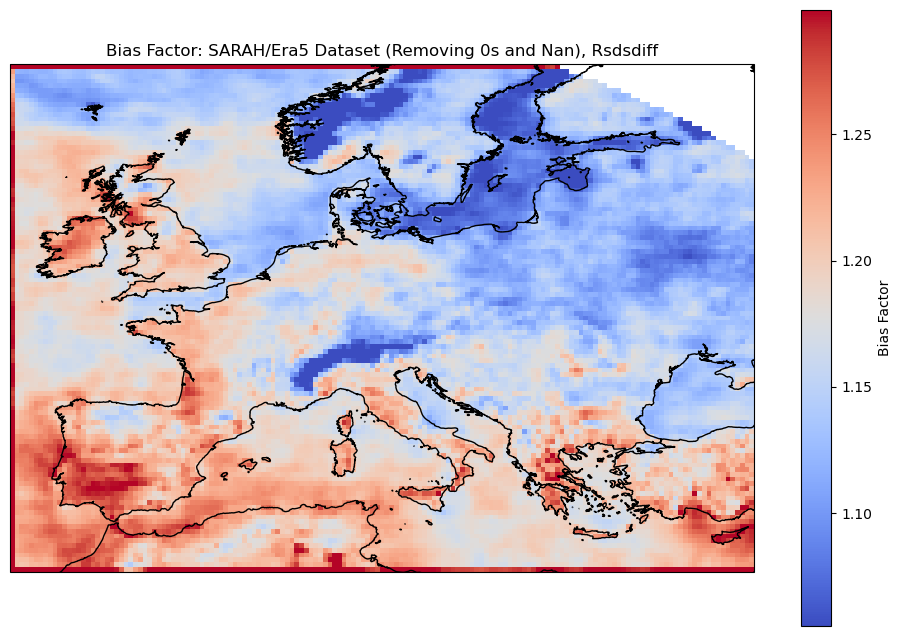

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming these variables exist
denominator_rsdsdiff = rsdsdiff_era5_mean_interp_cut.values  # ERA5 dataset
numerator_rsdsdiff = rsdsdiff_sarah_mean_cut.values  # SARAH dataset

# Ensure valid bias factor calculation
mask_valid_rsdsdiff= (denominator_rsdsdiff != 0) & (numerator_rsdsdiff != 0)  # Avoid division by zero and all values in SARAH that have mean 0
biased_values_rsdsdiff = np.where(mask_valid_rsdsdiff, numerator_rsdsdiff / denominator_rsdsdiff, np.nan)  # Replace invalid cases with NaN

# Ensure correct shape (remove extra dimension if it exists)
biased_values_rsdsdiff = np.squeeze(biased_values_rsdsdiff)  # Remove extra dimensions (e.g., (2, 131, 177) to (131, 177))

# Check if the biased_values shape matches lon2d, lat2d
# Get lat/lon values
lon = rsdsdiff_sarah_mean_cut.lon.values
lat = rsdsdiff_sarah_mean_cut.lat.values

# Ensure lon/lat are 2D using meshgrid
lon2d, lat2d = np.meshgrid(lon, lat)

# Use percentiles to remove outliers
vmin = np.nanpercentile(biased_values_rsdsdiff, 2)  # 2nd percentile (lower bound)
vmax = np.nanpercentile(biased_values_rsdsdiff, 98)  # 98th percentile (upper bound)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, biased_values_rsdsdiff,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto',
    vmin=vmin, vmax=vmax  # Clip extreme outliers
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.set_title("Bias Factor: SARAH/Era5 Dataset (Removing 0s and Nan), Rsdsdiff")

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias Factor')

plt.show()

In [26]:
# Calculate the 2nd and 98th percentiles to exclude outliers
lower_percentile_rsdsdiff = np.nanpercentile(biased_values_rsdsdiff, 2)  # 2nd percentile
upper_percentile_rsdsdiff = np.nanpercentile(biased_values_rsdsdiff, 98)  # 98th percentile

# Print the percentiles to check their range
print(f"2nd Percentile: {lower_percentile_rsdsdiff}")
print(f"98th Percentile: {upper_percentile_rsdsdiff}")

# Mask the biased_values to keep only those within the 2nd and 98th percentiles
filtered_biased_values_rsdsdiff = biased_values_rsdsdiff[(biased_values_rsdsdiff >= lower_percentile_rsdsdiff) & (biased_values_rsdsdiff <= upper_percentile_rsdsdiff)]

# Calculate the mean of the filtered values
mean_bias_factor_era5_sarah_rsdsdiff = np.nanmean(filtered_biased_values_rsdsdiff)

print(f"Mean Bias Factor for Rsdsdiff(excluding outliers): {mean_bias_factor_era5_sarah_rsdsdiff:.3f}")

2nd Percentile: 1.055416226387024
98th Percentile: 1.2991875410079956
Mean Bias Factor for Rsdsdiff(excluding outliers): 1.172
